In [1]:
%%capture
!pip install tensorflow pandas pyyaml h5py

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [4]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [5]:
def R2(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [6]:
test = dict(np.load("./data/data_single_test.npz"))

In [7]:
model = tf.keras.models.load_model("model_single_1.h5", custom_objects={"rmse": rmse, "R2": R2})

In [8]:
X_test, y_test = [test[i.name] for i in model.inputs], test["score"]
evaluate = model.predict(X_test).squeeze()
evaluate = pd.DataFrame([y_test, evaluate], index=["target", "predicted"]).T
evaluate.corr()

,target,predicted
target,1.000000,0.907178
predicted,0.907178,1.000000


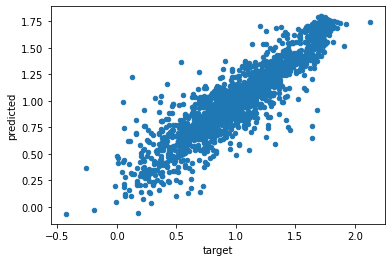

In [9]:
_ = evaluate.plot.scatter("target", "predicted")